## Optimizing changing window parameters

In [1]:
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
import IPython.display as ipd
from IPython.display import HTML
from jupyterthemes import jtplot
jtplot.style()
%config InlineBackend.figure_format = 'retina'

In [2]:
from adaptive_stft import optimize_stft

In [3]:
s = []
for i in [4, 8, 12]:
    x = torch.sin(torch.cumsum(2 * math.pi * torch.linspace(16, 8000 / (i + 1), int(8192 * 2 / (i + 1))) / (8192 * 2 / (i + 1)), 0))
    s.append(x)
rise = []
val = 0
for i in range(8192 + 1024):
    val += 1 / 8192
    if i > 4096:
        val += 4 / 8192 * math.pow((i - 4096) / 4096, 2)
    x = val * 500
    rise.append(math.sin(2 * math.pi * x))
s = torch.cat(s, dim=-1)
s = torch.cat((torch.from_numpy(np.array(rise)), s), dim=-1)

In [4]:
ipd.Audio(s.numpy(), rate=8192)

<Figure size 460.8x403.2 with 0 Axes>

100%|██████████| 9001/9001 [2:03:22<00:00,  1.22it/s, n_wnd=139, score=4.48, slope=70.8]  


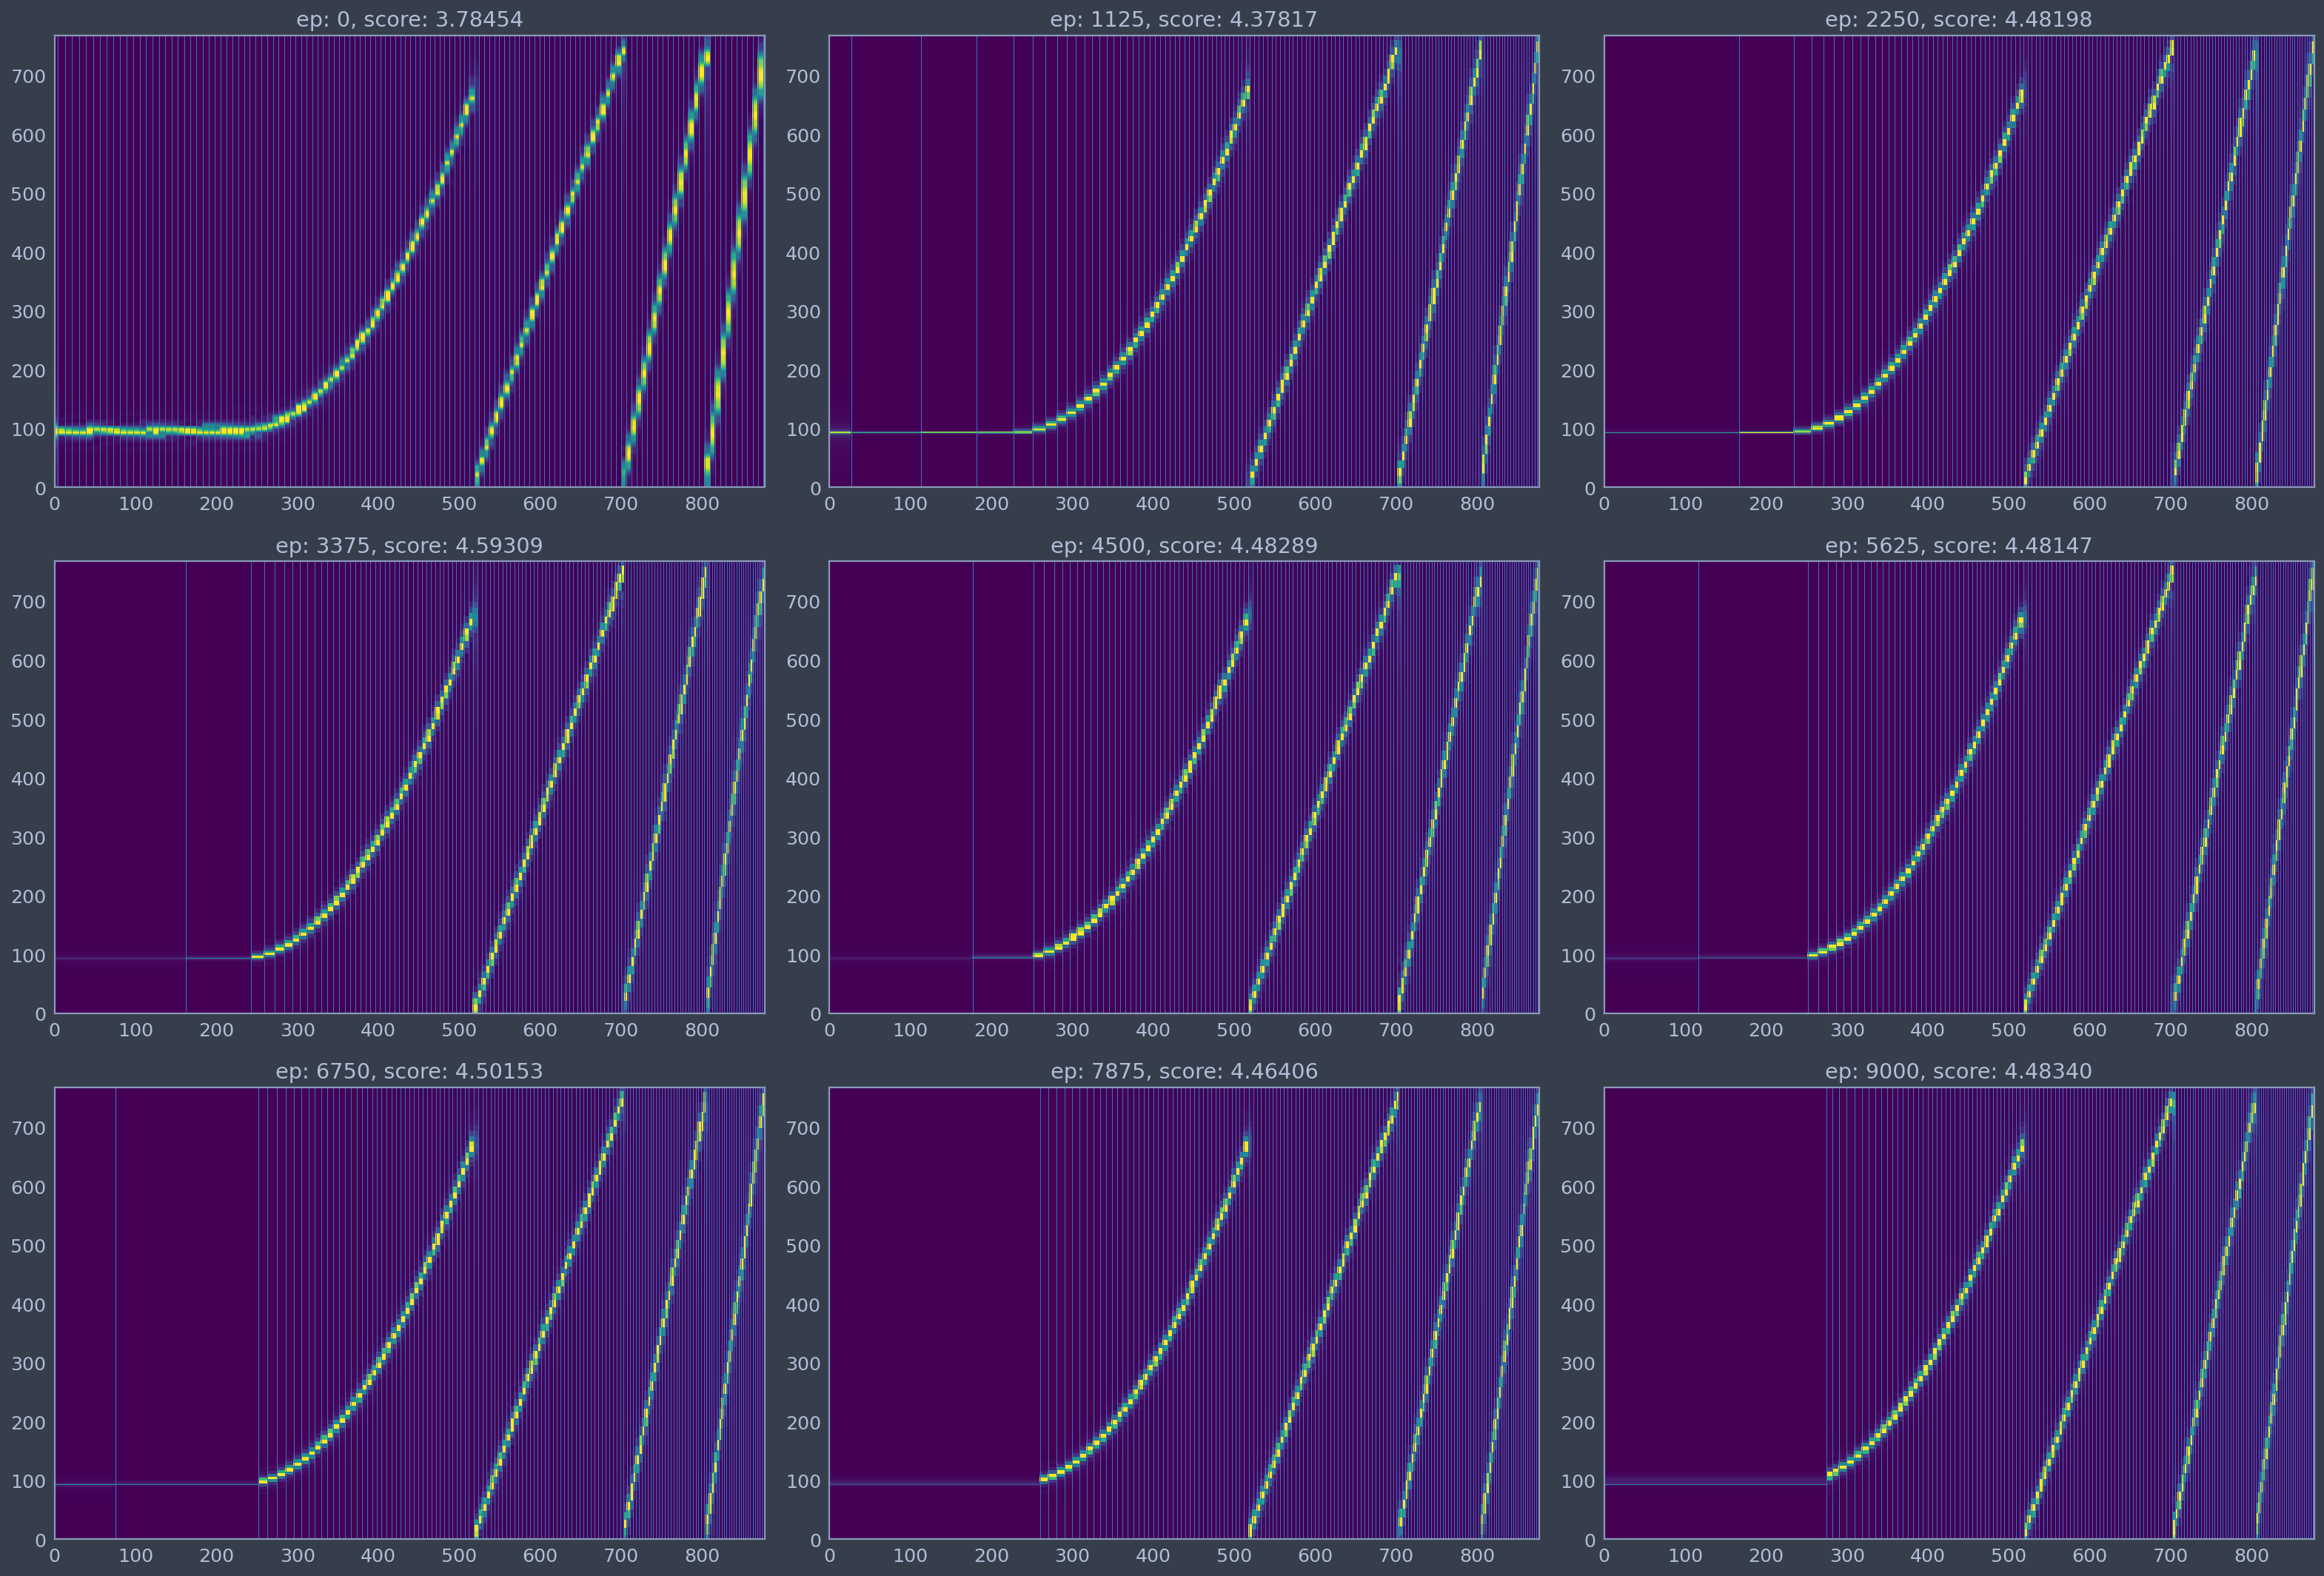

<Figure size 460.8x403.2 with 0 Axes>

In [5]:
import tqdm
if hasattr(tqdm.tqdm, '_instances'):
    tqdm.tqdm._instances.clear()
model, kur_hist, ani = optimize_stft(s.cuda(), lr=6e-5, num_windows=220, num_epochs=9000, window_shape='trapezoid', name_for_saving='sinesweep4_trape', make_animation=True)

In [7]:
HTML(ani.to_html5_video())

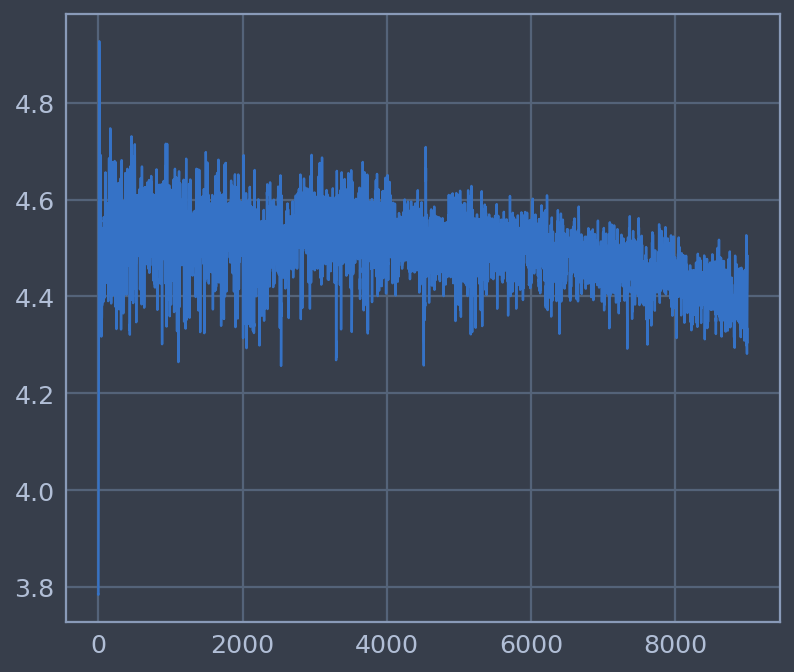

In [8]:
plt.plot(kur_hist)

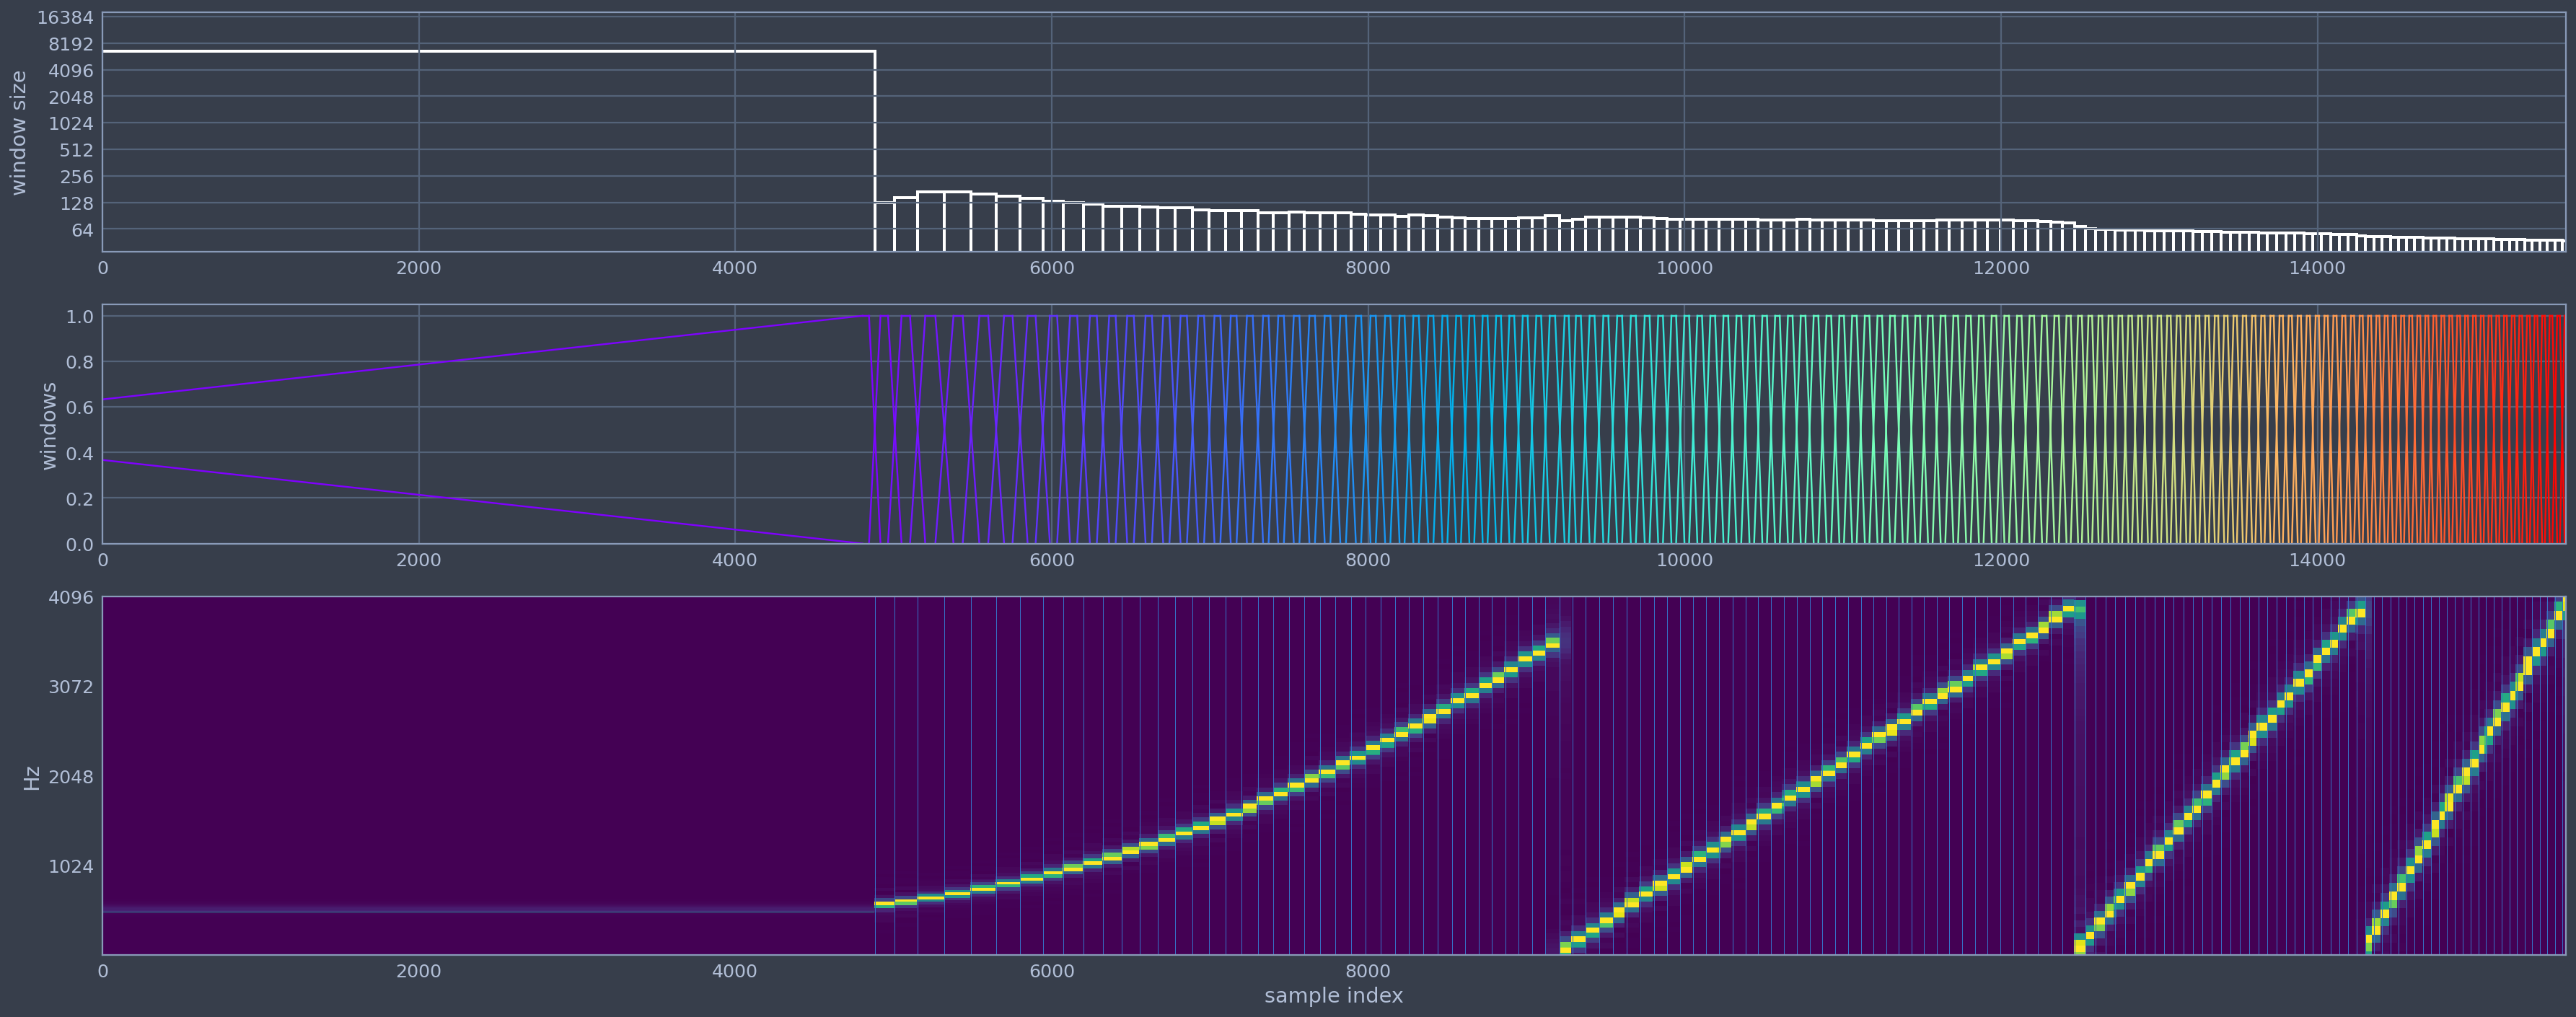

In [42]:
from adaptive_stft import make_window_extend_signal, apply_adaptive_window
from adaptive_stft_utils.mappings import make_find_window_configs

file = "sinesweep4_trape_plot_data_9000.npz"
all_data = np.load(file)
spectro = all_data["spectro"]
xs = all_data["x"]
ys = all_data["y"]
extend_left = all_data["extend_left"]
last_sample = int(all_data["sample_length"])
s = all_data["sample"]
s_ext = all_data["sample_extended"]

find_window_configs = make_find_window_configs(model, last_sample=last_sample)
configs = find_window_configs()
_, _, s_ext, extend_left = make_window_extend_signal(configs, torch.from_numpy(s).cuda(), window_shape='trapezoid')

xs_np = xs.copy()
ys_np = ys.copy()

fig_width = int(last_sample / 27000 * 14 * 10) / 10
plot_width = int(768 * fig_width / 7)

inter_window_lines = (xs + ys) / 2 - extend_left
inter_window_lines_delta = inter_window_lines[1:] - inter_window_lines[:-1]
xs_delta = xs_np[1:] - xs_np[:-1]
ys_delta = ys_np[1:] - ys_np[:-1]


import matplotlib.gridspec as gridspec
fig1 = plt.figure(constrained_layout=False)
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig1, height_ratios=[2, 2, 3])
f1_axes = [fig1.add_subplot(spec[i]) for i in range(3)]

width = inter_window_lines_delta
f1_axes[0].bar(inter_window_lines[:-1], inter_window_lines_delta, width=width, align='edge', color='None', edgecolor='white', lw=2)
f1_axes[0].set_yscale("log")
import matplotlib.ticker as ticker
f1_axes[0].get_yaxis().set_major_formatter(ticker.ScalarFormatter())
f1_axes[0].yaxis.set_major_locator(ticker.LogLocator(base=2, numticks=15))
f1_axes[0].set_ylabel("window size")
plt.margins(x=0)
f1_axes[0].set_xlim((0, s.shape[0]))


x = xs_np - extend_left
y = ys_np - extend_left
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0,1,x.shape[0] - 1)))
for i in range(x.shape[0] - 1):
    incx, incy = [y[i], x[i]], [0, 1]
    flatx, flaty = [x[i], y[i + 1]], [1, 1]
    decx, decy = [y[i + 1], x[i + 1]], [1, 0]
    c = next(color)
    f1_axes[1].plot(incx, incy, flatx, flaty, decx, decy, c=c)
f1_axes[1].set_ylabel("windows")
plt.margins(0)
f1_axes[1].set_xlim((0, s.shape[0]))
f1_axes[1].set_ylim((0, 1.05))


import matplotlib.colors
spectro_post = spectro[:, :].copy()
f1_axes[2].pcolormesh(spectro_post, norm=matplotlib.colors.Normalize(), linewidth=0)
for i in range(xs.shape[0]):
    inter_window_line = (xs[i] + ys[i]).item() / 2 - extend_left 
    if inter_window_line <= 0 or inter_window_line >= last_sample + 2000:
        continue
    f1_axes[2].axvline(inter_window_line / last_sample * plot_width, linewidth=0.5, antialiased=True)

positions = (0, 2000, 4000, 6000, 8000)
labels = [f'{x}' for x in positions]
f1_axes[2].set_xticks([x / last_sample * plot_width for x in positions])
f1_axes[2].set_xticklabels(labels)
f1_axes[2].set_xlim((0, plot_width))
f1_axes[2].set_xlabel("sample index")
positions = (1024, 2048, 3072, 4096)
labels = [f'{x}' for x in positions]
f1_axes[2].set_yticks([x / 4096 * 768 for x in positions])
f1_axes[2].set_yticklabels(labels)
f1_axes[2].set_ylabel("Hz")

fig = plt.gcf()
fig.set_size_inches(25, 10)
fig.set_tight_layout(True)
